<h1>Load Library</h1>

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

<p>Load data as model</p>

In [2]:
data = pd.read_csv('data/data.csv', encoding='latin-1')

alay_dict = pd.read_csv('data/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0:'original',1:'replacement'})

id_stopword_dict = pd.read_csv('data/stopwordbahasa.csv', header=None)
id_stopword_dict = id_stopword_dict.rename(columns={0:'stopword'})

In [3]:
data.head(5)

Tweet  HS  Abusive  \
0  - disaat semua cowok berusaha melacak perhatia...   1        1   
1  RT USER: USER siapa yang telat ngasih tau elu?...   0        1   
2  41. Kadang aku berfikir, kenapa aku tetap perc...   0        0   
3  USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...   0        0   
4  USER USER Kaum cebong kapir udah keliatan dong...   1        1   

   HS_Individual  HS_Group  HS_Religion  HS_Race  HS_Physical  HS_Gender  \
0              1         0            0        0            0          0   
1              0         0            0        0            0          0   
2              0         0            0        0            0          0   
3              0         0            0        0            0          0   
4              0         1            1        0            0          0   

   HS_Other  HS_Weak  HS_Moderate  HS_Strong  
0         1        1            0          0  
1         0        0            0          0  
2         0        0            0          0  
3         0        0            0          0  
4         0        0            1          0

In [4]:
data.describe()

HS       Abusive  HS_Individual      HS_Group   HS_Religion  \
count  13169.000000  13169.000000   13169.000000  13169.000000  13169.000000   
mean       0.422280      0.382945       0.271471      0.150809      0.060217   
std        0.493941      0.486123       0.444735      0.357876      0.237898   
min        0.000000      0.000000       0.000000      0.000000      0.000000   
25%        0.000000      0.000000       0.000000      0.000000      0.000000   
50%        0.000000      0.000000       0.000000      0.000000      0.000000   
75%        1.000000      1.000000       1.000000      0.000000      0.000000   
max        1.000000      1.000000       1.000000      1.000000      1.000000   

            HS_Race   HS_Physical     HS_Gender      HS_Other       HS_Weak  \
count  13169.000000  13169.000000  13169.000000  13169.000000  13169.000000   
mean       0.042980      0.024527      0.023236      0.284000      0.256891   
std        0.202819      0.154685      0.150659      0.450954      0.436935   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        HS_Moderate     HS_Strong  
count  13169.000000  13169.000000  
mean       0.129471      0.035918  
std        0.335733      0.186092  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

<h1>Check if null</h1>

In [5]:
data.isna().sum()

Tweet            0
HS               0
Abusive          0
HS_Individual    0
HS_Group         0
HS_Religion      0
HS_Race          0
HS_Physical      0
HS_Gender        0
HS_Other         0
HS_Weak          0
HS_Moderate      0
HS_Strong        0
dtype: int64

In [6]:
alay_dict.head(5)

original               replacement
0  anakjakartaasikasik  anak jakarta asyik asyik
1         pakcikdahtua         pak cik sudah tua
2       pakcikmudalagi         pak cik muda lagi
3          t3tapjokowi              tetap jokowi
4                   3x                 tiga kali

In [7]:
id_stopword_dict.head(5)

stopword
0      ada
1   adalah
2   adanya
3   adapun
4     agak

<h1>Plot Abusive</h1>

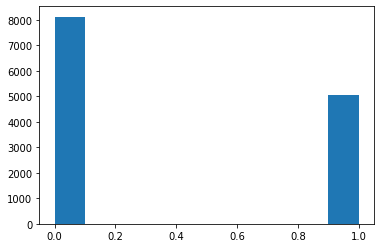

In [8]:
plt.hist(data.Abusive)
plt.show()

<h1>Count positif dan negatif</h1>

In [9]:
data.Abusive.value_counts()

0    8126
1    5043
Name: Abusive, dtype: int64

<h1>Preprocessing data</h1>

In [10]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    # text = text.lower()
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text) # Remove every '\n'
    
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url',' ',text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(':', ' ', text)
    text = re.sub(';', ' ', text)
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text) # Remove every '\n'
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text

def remove_nonalphanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text)
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    # text = ' '.join([alay_dict_map[word] if word in alay_dict_map else word in text.split(' ')])
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in id_stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text
    
def stemming (text):
    return stemmer.stem(text)

def remove_emoticon_byte(text):
    text = text.replace("\\", " ")
    text = re.sub('x..', ' ', text)
    text = re.sub(' n ', ' ', text)
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text)
    return text

def remove_early_space(text):
    if text[0] == ' ':
        return text[1:]
    else:
        return text

In [11]:
def preprocess(text):
    text = lowercase(text) # 1
    text = remove_emoticon_byte(text)
    text = remove_unnecessary_char(text) # 2
    text = remove_nonalphanumeric(text) # 2
    text = normalize_alay(text) # 3
    text = stemming(text) # 4
    text = remove_stopword(text) # 5
    # text = remove_early_space(text)
    return text

def classify(abusive):
    retval = ""
    if int(abusive) == 1:
        retval = 'yes'
    else:
        retval = 'no'
    return retval

In [12]:
data['Tweet'] = data['Tweet'].apply(preprocess)
#data['Abusive'] = data['Abusive'].apply(classify)
data[['Tweet', 'Abusive']].sample(10)

Tweet  Abusive
13163  orang yahudi kristen muslim be emu kumpul mala...        0
12041       aimu partai demokrasi indonesia juang bajing        1
2363   bagus negara kafir tat ustad hijrah k thailand ya        1
582    cebong kasih fakta bilang dusta cebong kasih d...        1
7511                               aduh sibuk iya celeng        1
10708  orang orang tawar rumah sih yahudi jual tingga...        0
11338                            lit as fuck silit entot        1
9906            selamat natal hehe dasar sih admin bolot        1
1744   langsung nikah kepala teknologi alam budaya se...        0
9025     percaya susah presiden percaya fatwa nabi palsu        0

In [13]:
# data['Tweet'] = data['Tweet'].apply(preprocess)

In [14]:
df = data[['Tweet','Abusive']]
df.to_csv("data/data_after_PreProcesing(steaming Original).csv", index = False)
df.head()

Tweet  Abusive
0  cowok usaha lacak perhati gue lantas remeh per...        1
1  telat tau edan sarap gue gaul ciga ifla cal licew        1
2  41 kadang pikir percaya tuhan jatuh kali kali ...        0
3                            ku tau mata sipit lihat        0
4          kaum cebong kafir lihat dongok dungu haha        1